# Assignment 4: Web Performance

### Due 5:00 p.m. Tuesday, May 10, 2016

### Background

In this assignment, you will build a caching web proxy that incorporates various performance optimizations to improve Web performance. Many of the optimizations that you will explore in this assignment are similar to those that ISPs and content providers alike are designing and implementing on their networks to improve Web performance.

You'll build on the web proxy that you implemented in assignment one by adding various performance optimizations, and then apply various web performance analysis techniques to analyze the effects of your performance improvements.

### Getting Started
* On your host machine (laptop), go to the course directory. 
```bash 
$ cd COS461-Spring2016
```

* Now, pull the latest update from Github.
```bash
$ git pull
```

* Reprovision your VM as follows: 
```bash
$ vagrant reload --provision
```
* You  will  find the  programming  assignment  in  the vm  under  the
  following directory:
```bash
vagrant@cos461:~$ ls /vagrant/notebook/assignment4
Assignment4-Web-Performance.ipynb  dev  figures  README.md  scripts
```

* You will find the following files in the `dev` directory:
```bash
vagrant@cos461:~$ ls /vagrant/notebook/assignment4/dev
http_client.go         Makefile          proxy4.go          README            
```

This notebook is for visualization only, so you will not change any of the code in the cells below. However, to run different sets of experiments, you will change a few parameters in the cells that call the programs you will implement. You will implement this assignment entirely in Go using the start code in the assignment directory. The directory scripts contains Python files that you can use to work on the course VM directly instead of working on the notebook.

### Part 1: HTTP Proxy

In this part  of the assignment, you will extend  the proxy server you implemented  in the first assignment to  include  a few  performance enhancements.   You  will  implement   the  following:  caching, link prefetching, and  DNS prefetching. Your proxy  should be configurable, i.e., you should be  able to turn on/off each of  the new features, as you  will evaluate  the  performance improvement  that  each  feature yields.  All of the features  should be  off by default. To enable a feature, you should pass the parameter corresponding to the feature in
the command line, as we explain in detail below.

Run the proxy with the following command:

`./proxy [parameters]`

The parameters are:

* `-port=NUMBER`,  if present,  set the  listening  port of  the proxy  to NUMBER. The default is 8080.

* `-dns`, if present, turn on DNS prefetching.

* `-cache`, if present, turn on caching.

* `-timeout=NUMBER`, if present, change the default value of cached object to NUMBER seconds. The default value  is 120 seconds. The section about caching gives more details about this parameter.

* `-max_cache=NUMBER`,  if   present,  set  the  maximum   cache  size  to NUMBER. The default value is 10MB.

* `-max_obj=NUMBER`, if present, set the  maximum size of objects that can be cached.  Objects larger than `max_obj`  must not be cached.  For the object size, consider only the body  of an HTTP response, i.e, do not consider the bytes in the HTTP headers and in the status-code line. The default value is 500KB.

* `-link`, if present, turn on link prefetching.

* `-max_conc=NUMBER`, if  present, set the  maximum number of  threads for link prefetching to NUMBER. The default value is 10.

* `-file=file_name`, if present, set the  log file name for the proxy. The default value is proxy.log.

We provide  an initial Go file  that parses the command  line and sets the corresponding global variables.

#### Getting Data From the Remote Server

You  will  change your  proxy  to send  HTTP/1.1 requests   to   the  server.    You will also  add   the   header <b>`Accept-Encoding`</b> with the value <b>`gzip`</b>.

Accept from the client:

<pre>GET http://www.princeton.edu/ HTTP/1.1
</pre>

Send to remove server:
<pre>GET / HTTP/1.1
Host: www.princeton.edu
Accept-Encoding: gzip
(Additional client specified headers, if any)
</pre>

By adding support to gzip, you will be able to test your proxy with Firefox without changing its default behavior. Also, you will observe performance improvement over the proxy of Assignment 1.

#### DNS Prefetching

DNS prefetching is a technique whereby the web proxy may resolve domain names for embedded links before a user clicks on any of the links. The idea behind DNS prefetching is to improve page load time by reducing the time required to perform a DNS lookup. DNS prefetching relies on a simple prediction: If a user asks  for a particular page, the odds are that he or she will next request a page linked from that page. DNS  prefetching uses this information to attempt to speed up browsing by parsing requested pages for links, and subsequently resolving the  server names that are  linked from the requested pages.  Resolving the domain names in advance reduces overall page load time by reducing the time required for DNS lookups when a user requests a subsequent page.

In this assignment, you will parse HTML pages that that a client requests and issue queries to populate the cache of the DNS resolver with the addresses  of all servers that are linked  from the requested pages. When your proxy attempts to connect to a server whose address is cached in the DNS resolver, the resolver will return a response much more quickly, as it does not need to issue a new query and wait for a response. Note that you do not need to implement a DNS cache in your proxy.

To parse an HTML page,  you  will need  to study  the Go  package <b>`net/html`</b>.   Since you  are accepting  gzip files,  you will  need to study the Go package <b>`compress/gzip`</b>.

#### Caching Web Objects

Caching is one of the most common performance enhancements that web proxies implement. Caching takes advantage of the fact that many pages on the web do not change that often, and that a user who visits a page is likely to visit the same page at some point in the future; many users who share a common web proxy can benefit from objects and pages that are cached as a result of other users' requests.  A caching  proxy server saves  a copy  of the  objects (i.e., files) that  it retrieves from "origin" web servers. When another request comes  in for the same  object, the cache returns  the  saved (or  cached)  copy instead  of retrieving the object from the origin server.  By returning the cached object to the client, a cache can significantly reduce the overall time to load a web page a more distant server or a remote server that is overloaded (it can also help reduce the load on heavily trafficked servers).

Caching  introduces a  few new complexities as  well.  First, you'll need  to alter how  your proxy  retrieves pages. Your proxy should now check to see whether a page exists  in the proxy memory before retrieving a page from a remote server.  HTTP defines a complex caching model where web servers  can give instructions  as to  how the objects  they serve should be cached and clients can  specify how caches are used on their behalf. The header <b>`Cache-Control`</b> in  a request or response defines the instructions to  the proxy. You can  read Section 14.9 of  RFC 2116 for the details of the cache control mechanisms in HTTP.

https://www.w3.org/Protocols/rfc2616/rfc2616-sec14.html

In this assignment, you  will use a simplified approach.  When your proxy  queries a  web server  on behalf of a client, you should cache the  object in  memory as  you transmit it  back to  the client, unless  the  `Cache-Control`  header  of  the  response  contains  the <b>`no-cache`</b> instruction.  If  another client requests the same object at  some later time, your  proxy does not need  to retrieve the object from the server again if it  is still valid. To determine if an object is still valid,  you need to check if it is in  the cache for a time shorter  than the parameter  "timeout" that you specified  in the command line.   Thus, you will  need to  store the time  when the cached object  was retrieved  (retrieval time). If  the object  is not valid, you will  issue a <b>conditional GET request</b> to  the web server. A conditional GET  includes a  header <b>`If-Modified-Since`</b> and  returns a copy of the object only if it was modified on the web server.

An example of the If-Modified-Since header is:

       If-Modified-Since: Sat, 29 Oct 1994 19:43:31 GMT

If the  object has  not been  modified since  the specified  time, the server will respond with a status code 304. Otherwise, the server will respond as  if the request  were a normal  GET, i.e., the  server will respond with a status code 200 if the object were found.

After the  GET command, you  should update  the retrieval time  of the object, even if a  new copy of the object was  not returned.

Note  that  the If-Modified-Since  header  requires  the RFC1123  date format.  You can  get  a string  in this  format  using the  following commands in Go:

`modifiedTime := storedTime.UTC()`

`timeString   := modifiedTime.Format("Mon, 02 Jan 2006 15:04:05 GMT"))`

storedTime stores the time the proxy retrieved the object. You need to declare the storedTime variable in your cache data structure.

Needless  to say,  if  your proxy  stores every  object  that is  ever requested, it  will require unlimited memory.   To limit the amount of memory required (and to simplify testing) you will establish a maximum cache size and evict objects  from the cache when the size  exceeds this maximum. The maximum cache  size is specified in the command  line when you run your proxy.

You will implement the  Least Recently  Used (LRU)  cache replacement policy  when deciding  which objects  to evict.   Note that reads and writes of a cached object both count as “using” an object.

Another  problem  is  that  some  web objects  are  much  larger  than others. It is  probably not a good idea to  replace several objects in your cache with one single big object. Therefore, you will not cache objects larger than the parameter `max_obj` specified in the command line.

Because this cache is a shared resource among your connection threads, you must  make sure your  cache is  thread-safe. A simple strategy to make your cache thread-safe is to use  a mutex lock to  ensure that a thread writing to the cache is the only one accessing it.

#### Link Prefetching

The basic intuition behind link prefetching is   similar    to   DNS prefetching. Instead of prefetching DNS names, however, your proxy will parse requested pages for links and fetch the linked pages in the  background.  The pages fetched from the links are stored in  the cache, ready to be served to the client when  they are requested without the client  having to wait around for the remote server to be contacted.

Parsing and  fetching links  can take an  appreciable amount  of time, especially for a page with a lot of links. For this reason, you should spawn  a Go  routine for  each link  that you  will prefetch,  but you should limit  the maximum number  of threads  to `max_conc`, which  is a command-line parameter.  To limit the number of threads, you must use Go channels. You don't need to prefetch embedded objects, as the  browser will issue  the requests anyway.  Therefore, you just need to look  for "a" tags with key "href" and prefetch those. Note that the proxy must not prefetch links for HTTPS.

If link  prefetching is  on, you should  not perform  DNS prefetching, even if  `dns` is passed  in the command  line, as the  link prefetching will issue  DNS requests anyway. On  the other hand, you  have to turn caching on, even if caching is not specified in the command line.


### Part 2: HTTP Client

In this part of the assignment, you will implement an HTTP client in Go with different modes of behavior specified in the command-line parameters. The parameters for the HTTP client are listed below and are explained in more detail in the sections below:

`./http_client [parameters]`

* `-url=URL` specifies the URL.

* `-waterfall`, if present, select the waterfall behavior for the client.

* `-browser`, if present, select the browser behavior for the client.

* `-outfile=FILENAME`  specifies the  filename  for the  waterfall or  the browser measurements.

* `-num_reqs=NUMBER` specifies the number of links that will be randomly fetched. The default value is 20.

* `-init_time=NUMBER` specifies the number of seconds to sleep before the start of link fetching. The default value is 30 seconds.

* `-sleep_time=NUMBER` specifies the number of seconds to sleep between two link fetches. The default value is 5 seconds.

* `-proxy=IP_ADDRESS:PORT` specifies the IP address and port number of the proxy for the simulated browser. If proxy is not specified, you should fetch the urls directly from their servers. 

#### HTTP Waterfall

To better understand and appreciate the effects of different performance optimizations, it helps to understand what aspects contribute to webpage load time. Much like you might "profile" an application to determine which parts of your code are running slowly, you can look at the process of loading a webpage to determine which parts of the page load are contributing most to overall load time. A common way to visualization for web performance is an HTTP waterfall.

An  HTTP waterfall  chart  is a  diagram that  depicts  the series  of actions that  occur between a  user and a server  until a Web  page is displayed in  a user’s browser.  Each  row of the chart  represents an object (text, images, JavaScript, 3rd party components, etc.)  that a Web page  contains and shows the  round-trip time between the  user and the server. Whenever  one single object  on the page underperforms, your user experience will be negatively affected.

A waterfall chart reveals six key metrics: 

* DNS Lookup Time: This is when the browser looks up the domain of the  requested page.

* Connecting: This  shows the  user  and the  server sending  and receiving acknowledgment that a connection has been made, and data can begin to be transferred. This is the  time it takes for TCP connect to execute.

* Time to First Byte: This is the window of time between asking for Web content and getting the first byte back from the  server.

* Content Download:  This is the time it takes  for every piece of content to be  sent from the server  back to the user  browser.

* Start Render: This  is the  time it takes  for the  browser to start displaying the page.

* Document Complete: This is the  time it takes for your Web page to fully load in the browser.

You can visit the  site http://www.webpagetest.org/ and test different URLs to see  how an HTTP Waterfall looks like.  Alternatively, you can see waterfall charts on the Chrome  browser by right clicking  on the page and selecting "Inspect" and then clicking on the "Network" tab.

The New York Times published  an interesting article  about impatient web users and how download times matter for the success of a business. The article is  illustrated with a picture of an  engineer analyzing a waterfall chart.  You can read the full article at

http://www.nytimes.com/2012/03/01/technology/impatient-web-users-flee-slow-loading-sites.html?_r=0


In this  assignment, you  will implement a  simplified version  of the waterfall chart.  You will implement  an HTTP client that  receives a URL in the command line and generates the load time for:

1. DNS Lookup Time

2. Connecting

3. Content Download

You will generate the data corresponding  to each bar in the following format:

* DXX start_time end_time

* TYY start_time end_time

* LXX start_time end_time

DXX  is for  DNS requests,  TYY is  for TCP  connect, and  LZZ is  for content  download  times.   The  double  letters  after  the  initials represent  sequential  numbers,  e.g,  D01, T01,  L01  for  the  first occurrence of the  initial.  `start_time` and `end_time` should  be a time in  milliseconds relative  to  the beginning  of  the execution.   You should store  the time of  the beginning  of the client  execution and then compute  the difference for determining  `start_time` and `end_time`.

One important difference between the waterfall you will generate and those generated by a browser is that your client will issue each HTTP request sequentially; in contrast, browsers typically send multiple parallel requests. Consequently, the total time to load a page will be significantly higher than you would observe on a browser, but the analysis will be much simpler.

You will initially compute the three times listed above for the URL that you pass to the client at the command line.  Then, you will parse the HTML file and download the  embedded images  only (objects with  a tag  "img").  For each image,  you will always  compute the Connecting time  and Content Download time, but you will not compute the DNS time if the web server was previously accessed.  Therefore, you should keep a dictionary that maps server names  to IP addresses to avoid the  DNS lookup time (this DNS  caching is  something  that  the browsers  do,  so  you would  be mimicking the browser  behavior). Note that the net.Dial  method of Go does a  DNS lookup  if you  pass the  server name,  but it  avoids the lookup if you pass the IP address of the server.

You will save the data in a file; you will pass the filename as a parameter at the command line.

The cell bellow generates a waterfall chart and the cell after calls the HTTP client and plot the waterfall chart.
(The starter code contains a function that will save the data in the proper format to a file).

In [15]:
"""
Creates a simple Gantt chart
Adapted from https://bitbucket.org/DBrent/phd/src/1d1c5444d2ba2ee3918e0dfd5e886eaeeee49eec/visualisation/plot_gantt.py
BHC 2014
"""
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib import colors as plot_colors 
from pylab import *

import os
import sys
import math
from subprocess import Popen, PIPE, call

%matplotlib inline 

COLORS = plot_colors.cnames.keys() 

def get_color(ind):
    global COLORS
    return COLORS[ind % (len(COLORS))] 

def waterfall(data):

    data_items = data.items()
    data_items = sorted(data_items, key = lambda x : x[1][0])
    labels = [x[0] for x in data_items]

    mymax = 0.5*len(labels)+0.5
    pos = arange(0.5,mymax,0.5)
 
    # Initialise plot
 
    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111)
    # Plot the data
 
    start, end = data[labels[0]]
    ax.barh(0.55, (end - start), left=start, height=0.4, align='center', color = get_color(0))
    for i in range(0,len(labels)-1):
        start, end = data[labels[i+1]]
        ax.barh((i*0.5)+1.0+0.05, (end - start), left=start, height=0.4, align='center', color = get_color(i + 1))
 

    # Format the y-axis
    locsy, labelsy = yticks(pos,labels)
    plt.setp(labelsy, fontsize = 10)
    plt.ylabel('Object (D=DNS, T=TCP Connect, L=Load)', fontsize=16)
 
    # Format the x-axis
    ax.axis('tight')
    ax.set_ylim(ymin = -0.1, ymax = mymax)
    ax.grid(color = 'g', linestyle = ':')
 
    labelsx = ax.get_xticklabels()
    plt.setp(labelsx, rotation=30, fontsize=12)
    plt.xlabel('Time (ms)', fontsize=16)
 
    # Format the legend
 
    font = font_manager.FontProperties(size='small')
    # ax.legend(loc=1,prop=font)
 
    # Finish up
    ax.invert_yaxis()
    fig.autofmt_xdate()
    plt.show()

def get_data(fname):
    f = open(fname, 'r')
    data = {}
    for line in f.readlines():
        parts = [x.strip() for x in line.split()]
        if len(parts) > 2:
            data[parts[0]] = [float(parts[1]), float(parts[2])]

    f.close()
    return data


#### Execute the client and Plot the Waterfall

The cell below executes your HTTP client and plot the Waterfall chart.

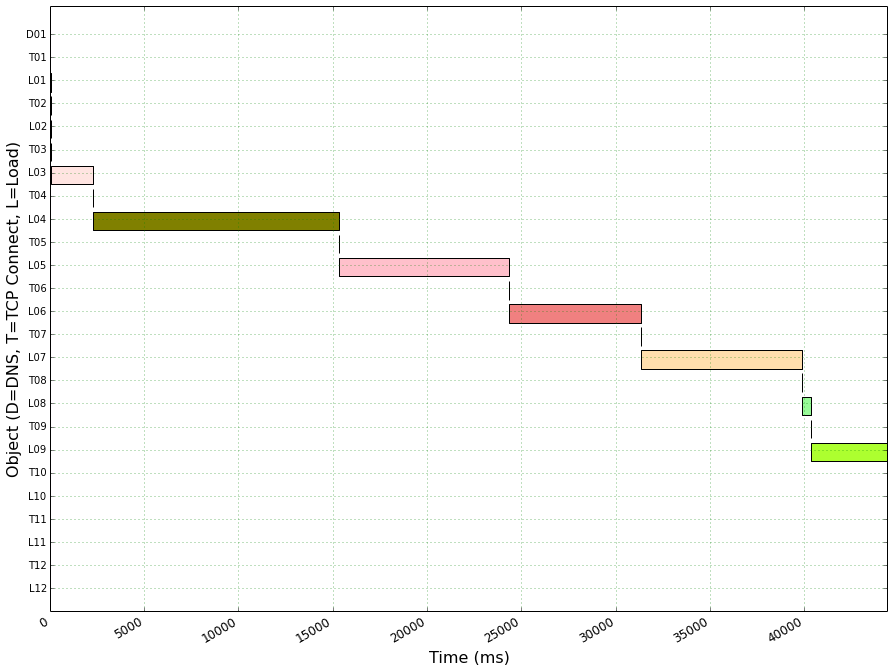

In [16]:
import os
import sys
import math
from subprocess import Popen, PIPE, call

Popen("./dev/http_client -url=http://www.cs.princeton.edu/ -waterfall -file=./dev/chart > /dev/null", shell=True).wait()
data = get_data('./dev/chart')
waterfall(data)

#### Browsing Simulation

Your task is  to build an HTTP client that  will retrieve HTTP objects and  measure  the response  time  of  your   proxy  under  different performance enhancements from Part 1. Your client will initially fetch a page, whose URL is passed as a parameter in the command line,  parse the page, and  issue new requests for  links that are present in the initial  page. More specifically, after the initial page is fetched, the client should sleep for `init_sleep` seconds and then issue `num_reqs` requests for randomly selected links  in the initial page (`init_sleep` and `num_reqs` are parameters specified in the command line). You will look for links  with "a" tags and  key "href". As  in Part 1, you  must not fetch links for HTTPS.


### Part 3: Proxy Performance Measurements

#### Execution Environment

You will run a few experiments in an emulated Mininet topology. We have provided you with the following mininet network topology:

<img width=600 src="figures/network_setup.png">

We have introduced an artificial delay between the private network and the public  Internet. This delay, typical of  long-distance links, will help you understand the possible benefits of a caching proxy.

To run an experiment (detailed below), you will run the HTTP client on the host `client`,  and the proxy  server on  the host `proxy`.

#### Measurements

To measure the performance of  your caching proxy, you  will first use  your  HTTP client  to  retrieve  the  objects directly  from  the origin server to get the base  numbers for each  retrieved page. Then, you  will disable all of the performance  enhancements and run your HTTP client to measure the cost of going through an unoptimized proxy.   Finally, you  will   enable  each   optimization individually and repeat the experiment  you ran with the optimizations disabled. Note  that   link  prefetching is  equivalent to all optimizations enabled.   

In summary, you will  analyze the performance benefits, and costs, of web caching proxy servers  by retrieving each object in three ways:

1. From the caching proxy's cache. [Should yield the best performance]

2. Directly from the object's originating web server. [Base case]

3. From the  caching proxy, which in turn retrieves  the page from the server (no  performance enhancement enabled). [Should  yield the worst performance]


You write a README, as part of your submission, that describes the optimizations that are more effective.

To  collect the  data from  your measurements,  you should  update the following statistics variables that are declared in proxy4.go in the start code:

* clientRequests: total number of HTTP requests

* cacheHits: number of requests that were served from the cache (cache hits). 

* cacheMisses: number of requests that were not served from the cache (cache misses).

* cacheEvictions: number of objects evicted from the cache.

* trafficSent: number of bytes sent to the clients.

* volumeFromCache: number of bytes sent from the cache to the clients.

* downloadVolume: number of bytes that your proxy downloaded.

These variables are shared with a thread that saves their values every minute. Therefore,  you should protect  them with a lock  whenever you read or write  to them. The starter code already defines a RW lock to  protect the statistics variables.   A RW  lock  allows concurrent accesses for read-only operations, but guarantees exclusive access for write operations. In Go, RW locks are available in the sync package.

The variables cacheHits and cacheMisses must be incremented for objects that you are prefetching, too. More specifically, before prefetching an object, you need to check the cache for its presence. If the object is present,  increment the variable cacheHits and do not retrieve it again from the web server. Otherwise, increment the variable cacheMisses.

#### Create Mininet Topology

The cell below creates the Mininet topology for the experiments.

In [7]:
from mininet.cli import CLI
from mininet.log import lg, info
from mininet.node import Node, OVSController, CPULimitedHost
from mininet.util import quietRun
from mininet.topo import Topo
from mininet.net import Mininet
from mininet.link import TCLink

#################################
class NetTopo(Topo):

    def __init__(self):
        super(NetTopo, self).__init__()

        client = self.addHost('client', ip = "192.168.0.1")
        proxy = self.addHost('proxy', ip = "192.168.0.2")
        
        s1 = self.addSwitch('s1')

        self.addLink(s1, client)
        self.addLink(s1, proxy)

def startNAT( root, inetIntf='eth0', subnet='192.168.0/24' ):
    """Start NAT/forwarding between Mininet and external network
    root: node to access iptables from
    inetIntf: interface for internet access
    subnet: Mininet subnet (default 10.0/8)="""

    # Identify the interface connecting to the mininet network
    localIntf =  root.defaultIntf()

    # Flush any currently active rules
    root.cmd( 'iptables -F' )
    root.cmd( 'iptables -t nat -F' )

    # Create default entries for unmatched traffic
    root.cmd( 'iptables -P INPUT ACCEPT' )
    root.cmd( 'iptables -P OUTPUT ACCEPT' )
    root.cmd( 'iptables -P FORWARD DROP' )

    # Configure NAT
    root.cmd( 'iptables -I FORWARD -i', localIntf, '-d', subnet, '-j DROP' )
    root.cmd( 'iptables -A FORWARD -i', localIntf, '-s', subnet, '-j ACCEPT' )
    root.cmd( 'iptables -A FORWARD -i', inetIntf, '-d', subnet, '-j ACCEPT' )
    root.cmd( 'iptables -t nat -A POSTROUTING -o ', inetIntf, '-j MASQUERADE' )

    # Instruct the kernel to perform forwarding
    root.cmd( 'sysctl net.ipv4.ip_forward=1' )

def stopNAT( root ):
    """Stop NAT/forwarding between Mininet and external network"""
    # Flush any currently active rules
    root.cmd( 'iptables -F' )
    root.cmd( 'iptables -t nat -F' )

    # Instruct the kernel to stop forwarding
    root.cmd( 'sysctl net.ipv4.ip_forward=0' )

def fixNetworkManager( root, intf ):
    """Prevent network-manager from messing with our interface,
       by specifying manual configuration in /etc/network/interfaces
       root: a node in the root namespace (for running commands)
       intf: interface name"""
    cfile = '/etc/network/interfaces'
    line = '\niface %s inet manual\n' % intf
    config = open( cfile ).read()
    if ( line ) not in config:
        print '*** Adding', line.strip(), 'to', cfile
        with open( cfile, 'a' ) as f:
            f.write( line )
    # Probably need to restart network-manager to be safe -
    # hopefully this won't disconnect you
    root.cmd( 'service network-manager restart' )

def connectToInternet( network, switch='s1', routerip='192.168.0.254', subnet='192.168.0/24'):
    """Connect the network to the internet
       switch: switch to connect to root namespace
       routerip: address for interface in root namespace
       subnet: Mininet subnet"""

    switch = network.get( switch )
    prefixLen = subnet.split( '/' )[ 1 ]
    routes = [ subnet ]  # host networks to route to

    # Create a node in root namespace
    router = Node( 'router', inNamespace=False )
    
    # Prevent network-manager from interfering with our interface
    fixNetworkManager( router, 'router-eth0' )

    # Create link between root NS and switch
    link = network.addLink( router, switch, delay='100ms')
    link.intf1.setIP( routerip, prefixLen )

    # Start network that now includes link to root namespace
    network.start()

    # Start NAT and establish forwarding
    startNAT( router )

    # Establish routes from end hosts
    for host in network.hosts:
        host.cmd( 'ip route flush root 0/0' )
        host.cmd( 'route add -net', subnet, 'dev', host.defaultIntf() )
        host.cmd( 'route add default gw', routerip )

    return router

#### Start Mininet

The cell below starts mininet.

In [8]:
from subprocess import call

call(["mn", "-c"])
topo = NetTopo()
net = Mininet(topo=topo, link=TCLink, host=CPULimitedHost, controller = OVSController)
# Configure and start NATted connectivity
router = connectToInternet(net)

#### Start Proxy Server

The cell below starts your proxy on the appropriate host. You will change the parameters of the proxy to run different experiments.

In [9]:
proxy = net.getNodeByName('proxy')
proxy.popen("./scripts/dnsmasq restart", shell=True).wait()
proxy.popen("./dev/proxy4 -file=./dev/proxy.log -link > /dev/null", shell=True) 

#### Run Client

The cell below starts your http_client on the client host. You will change the parameters of the client to run different experiments.

In [10]:
client = net.getNodeByName('client')
client.popen("./dev/http_client -url=http://www.cs.princeton.edu/ -browser -init_time=10 -sleep_time=1 -file=cs -proxy=192.168.0.2:8080 > /dev/null", shell=True).wait()

0

#### Show Cache Statistics

The cell below plots a graph with statistics of your proxy's cache. 

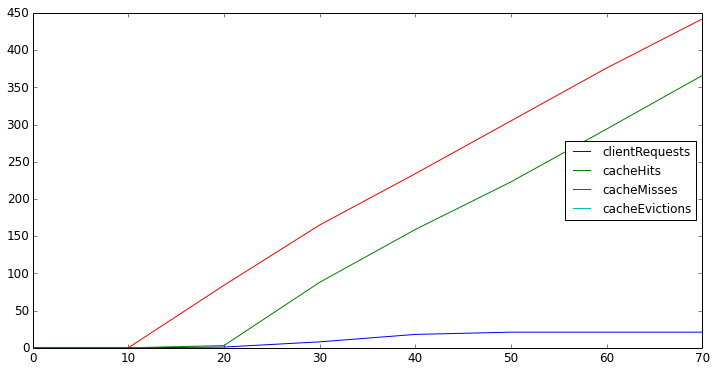

In [11]:
import sys
import matplotlib.pyplot as plt

%matplotlib inline
def plot(fname):
    f = open(fname, 'r')
    labels = f.readline()[1:].strip().split()
    

    data = [[], [], [], [], [], [], [], [], [], []]
    i = 0
    for line in f.readlines():
        parts = [float(x.strip()) for x in line.split() if len(x.strip()) > 0]
        if len(parts) > 9:
            for ind, l in enumerate(data):
                l.append(parts[ind]) 
    f.close()
    
    plt.figure(figsize=(12,6))
    time = data[0]
    for i in range(1, 5):
        plt.plot(time, data[i], label = labels[i])
    plt.legend(loc = 'center right')
    pos, labelsy = yticks()
    plt.setp(labelsy, fontsize = 12)
    pos, labelsx = xticks()
    plt.setp(labelsx, fontsize = 12)
    plt.show()
   
plot('./dev/proxy.log')

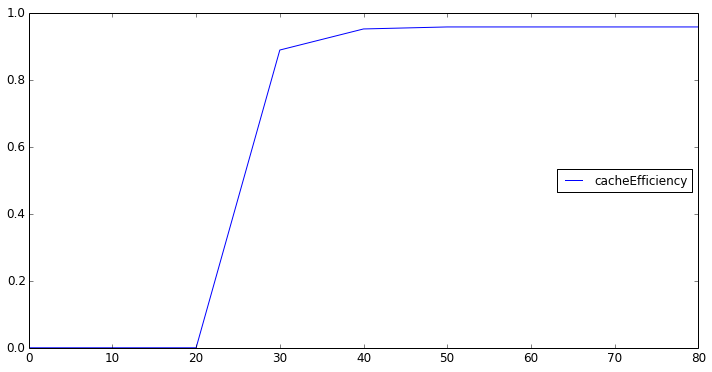

In [12]:
import sys
import matplotlib.pyplot as plt

%matplotlib inline
def plot(fname):
    f = open(fname, 'r')
    labels = f.readline()[1:].strip().split()
    

    data = [[], [], [], [], [], [], [], [], [], []]
    i = 0
    for line in f.readlines():
        parts = [float(x.strip()) for x in line.split() if len(x.strip()) > 0]
        if len(parts) > 9:
            for ind, l in enumerate(data):
                l.append(parts[ind]) 
    f.close()
    
    plt.clf()
    plt.figure(figsize=(12,6))
    time = data[0]
    pos, labelsy = yticks()
    plt.setp(labelsy, fontsize = 12)
    pos, labelsx = xticks()
    plt.setp(labelsx, fontsize = 12)
    
    plt.plot(time, data[9], label = labels[9])
    plt.legend(loc = 'center right')
    plt.show()  
   
plot('./dev/proxy.log')

#### Show Traffic Statistics

The cell below plots statistics of the traffic that were sent or received by your proxy.

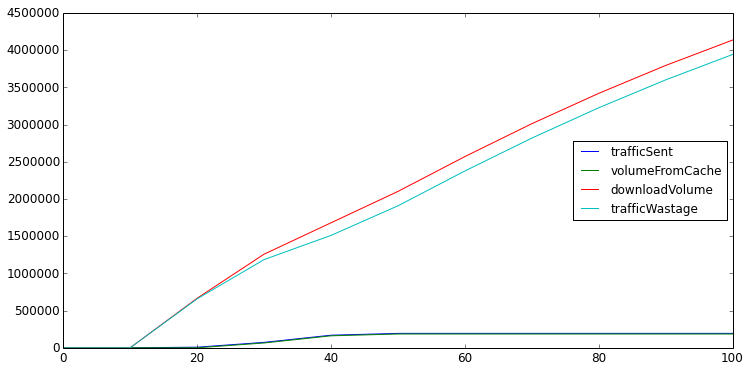

In [13]:
import sys
import matplotlib.pyplot as plt

%matplotlib inline
def plot(fname):
    f = open(fname, 'r')
    labels = f.readline()[1:].strip().split()
    

    data = [[], [], [], [], [], [], [], [], [], []]
    i = 0
    for line in f.readlines():
        parts = [float(x.strip()) for x in line.split() if len(x.strip()) > 0]
        if len(parts) > 9:
            for ind, l in enumerate(data):
                l.append(parts[ind]) 
    f.close()
    time = data[0]
    plt.clf()
    plt.figure(figsize=(12,6))
    time = data[0]
    pos, labelsy = yticks()
    plt.setp(labelsy, fontsize = 12)
    pos, labelsx = xticks()
    plt.setp(labelsx, fontsize = 12)
    
    for i in range(5, 9):
        plt.plot(time, data[i], label = labels[i])
    plt.legend(loc = 'center right')
    plt.show()
    
   
plot('./dev/proxy.log')

#### Stop Mininet

In [14]:
from subprocess import Popen, PIPE, call

# Stop local resolver at the proxy
proxy = net.getNodeByName('proxy')
proxy.popen("./scripts/dnsmasq stop")

# Shut down NAT
Popen("pgrep -f proxy4 | xargs kill -9", shell=True).wait()
stopNAT(router)

# Shutdown mininet
net.stop()

### Submission and Grading

#### Design Document

You will submit a design document by <b>Tuesday, May 3 23:59pm</b>. This is a relatively long assignment and we want to make sure that you start early. In your document, you will describe the following:

* the cache data struture;

* how you will use Go channels to limit the number of threads in link prefetching (use pseudo-code);

* how you will parse and process an html file (use pseudo-code).

Submit a text file (design.txt) with the description of your design decisions. Do not forget to include the names of the group members.

#### Source code
You should submit  your completed proxy and client by Dean's date, as described at the beginning of this doument, to [CS Dropbox (https://dropbox.cs.princeton.edu/COS461_S2016/Assignment4). You should submit a tarball file containing the following:

* Makefile and source code for the http client and proxy server

* README file describing your implementation

#### Grading 
This  assignment  is  worth  20  points,  with  the  following  points breakdown: two points for the design document, eight points for the http client, and ten points for the proxy server.